<a href="https://colab.research.google.com/github/Joyatulya/colab_notebooks/blob/main/NIH_CXR_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jun 23 11:32:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Enviornment Setup

In [ ]:
!git clone https://github.com/Joyatulya/utils.git

Cloning into 'utils'...
remote: Enumerating objects: 2054, done.
remote: Counting objects: 100% (2054/2054), done.
remote: Compressing objects: 100% (1762/1762), done.
remote: Total 2054 (delta 282), reused 2014 (delta 256), pack-reused 0
Receiving objects: 100% (2054/2054), 6.30 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [ ]:
from utils.enviornmet_setup import *
# mount_drive()
!mkdir /root/.kaggle
config_files()

Copying Kaggle/wandb/git


In [ ]:
!kaggle datasets download -d xhlulu/vinbigdata-chest-xray-resized-png-1024x1024
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-montgomery
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen
!kaggle datasets download -d nih-chest-xrays/data

100% 7.34G/7.35G [01:42<00:00, 103MB/s] 
100% 7.35G/7.35G [01:42<00:00, 76.7MB/s]
 99% 577M/585M [00:08<00:00, 52.3MB/s]
100% 585M/585M [00:08<00:00, 69.5MB/s]
100% 3.50G/3.51G [00:57<00:00, 91.4MB/s]
100% 3.51G/3.51G [00:57<00:00, 65.6MB/s]
100% 42.0G/42.0G [08:45<00:00, 107MB/s]
100% 42.0G/42.0G [08:45<00:00, 85.8MB/s]


In [ ]:
!mkdir ./nih
!unzip -qq data.zip -d ./nih
!cp ./drive/MyDrive/cxr/nih/full_working_nih_df.csv ./sample/full_working_nih_df.csv
!rm data.zip
!cp ./drive/MyDrive/cxr/nih/masks_nih.zip ./masks_nih.zip
!mkdir nih
!unzip -qq masks_nih.zip -d masks_nih
!rm masks_nih.zip

!mkdir ./vinbigdata
!unzip -q vinbigdata-chest-xray-resized-png-1024x1024.zip -d ./vinbigdata
!rm vinbigdata-chest-xray-resized-png-1024x1024.zip

!cp -r ./drive/MyDrive/cxr/vinbigdata/* ./vinbigdata

!mkdir montgomery
!unzip -q tuberculosis-chest-xrays-montgomery.zip  -d ./montgomery/
!rm tuberculosis-chest-xrays-montgomery.zip

!mkdir shenzhen
!unzip -q tuberculosis-chest-xrays-shenzhen.zip -d ./shenzhen/
!rm tuberculosis-chest-xrays-shenzhen.zip

!mkdir combined
!cp -r ./drive/MyDrive/cxr/tb/* ./combined

cp: cannot create regular file './sample/full_working_nih_df.csv': No such file or directory
mkdir: cannot create directory ‘nih’: File exists


In [ ]:
!cp ./drive/MyDrive/cxr/nih/worst_cxr.txt ./worst_cxr.txt
!cp ./drive/MyDrive/cxr/nih/last_cxr.txt ./last_cxr.txt
# !cp ./drive/MyDrive/predicted_full_nih.csv ./predicted_full_nih.csv

     |████████████████████████████████| 1.8 MB 14.2 MB/s 
     |████████████████████████████████| 181 kB 75.9 MB/s 
     |████████████████████████████████| 145 kB 79.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


#Libraries & Hyper

In [ ]:
!pip install -q libauc
!pip install -q wandb

     |████████████████████████████████| 1.8 MB 16.8 MB/s 
     |████████████████████████████████| 181 kB 77.8 MB/s 
     |████████████████████████████████| 145 kB 81.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np
import wandb
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import seaborn as sns

from glob import glob

from sklearn import metrics
from torchvision.io import read_image, ImageReadMode

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
from torch import nn

%env WANDB_START_METHOD=thread

SEED = 1996
torch.manual_seed(SEED)
wandb.login()

env: WANDB_START_METHOD=thread


wandb: Currently logged in as: joy_atulya. Use `wandb login --relogin` to force relogin


True

In [ ]:
BATCH_SIZE = 32
# BATCH_SIZE = 32
CHANNELS  = 3
IMG_SIZE = (384,384,CHANNELS)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BASE_FOLDER = os.path.join('drive', 'MyDrive', 'cxr')

AUX_DATA_COLUMNS = ['age', 'position','ct_ratio', 'ct_area', 'right_cp_angle', 'right_cp_angle_direction',
                    'left_cp_angle', 'left_cp_angle_direction', 'cp_rel_position',
                    'height_width_ratio', 'area_ratio', 'vertical_span_ratio', 'Gender']

categorical_cols = ['Gender', 'position']

numerical_cols = ['ct_ratio','ct_area','right_cp_angle','left_cp_angle',
                  'cp_rel_position','height_width_ratio','area_ratio','vertical_span_ratio']

# Have removed hernia from here
PATHOLOGY_LIST = ['Cardiomegaly','Emphysema','Effusion',
                  'Pneumothorax','Atelectasis','Mass','Edema','Consolidation',
                  'Fibrosis',]

configs = dict(
    data_flag = 'nih_full_pytorch',
    channels = CHANNELS,
    img_shape = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_names = PATHOLOGY_LIST,
    seed = SEED
)

print(f"Using {device} accelaration")


#Loading and Cleaning data
---

##Accessory Setup

In [ ]:
# vin_df = pd.read_csv('./vinbigdata/train.csv')
# column_list = ['image_id', 'class_name',]
# vin_df = vin_df.loc[:,column_list]
# images_vin = {os.path.basename(x).split('.')[0]: x for x in 
#                    glob(os.path.join('./vinbigdata/', '*', '*.png'))}
# vin_df['path'] = vin_df["image_id"].map(images_vin.get)

# def get_all_disease(image_id):
#   total_disease = vin_df[vin_df.image_id == image_id].class_name.values
#   total_disease = '|'.join(total_disease)
#   return total_disease

# vin_df['findings'] = vin_df['image_id'].apply(get_all_disease)
# working_vin_df = vin_df.loc[:,['image_id','path','findings']].drop_duplicates()
# working_vin_df['masks'] = './vinbigdata/masks/' + working_vin_df['image_id'] + '_mask.png'

In [ ]:
# vin_aux_df = pd.read_csv('./vinbigdata/vinbigdata_aux.csv')
# vin_aux_df.rename(columns = {'image_index' : 'image_id'}, inplace = True)
# working_vin_df = pd.merge(working_vin_df, vin_aux_df, on = 'image_id')

In [ ]:
resize = T.Resize((384,384))
threshold = nn.Threshold(40, 0.)

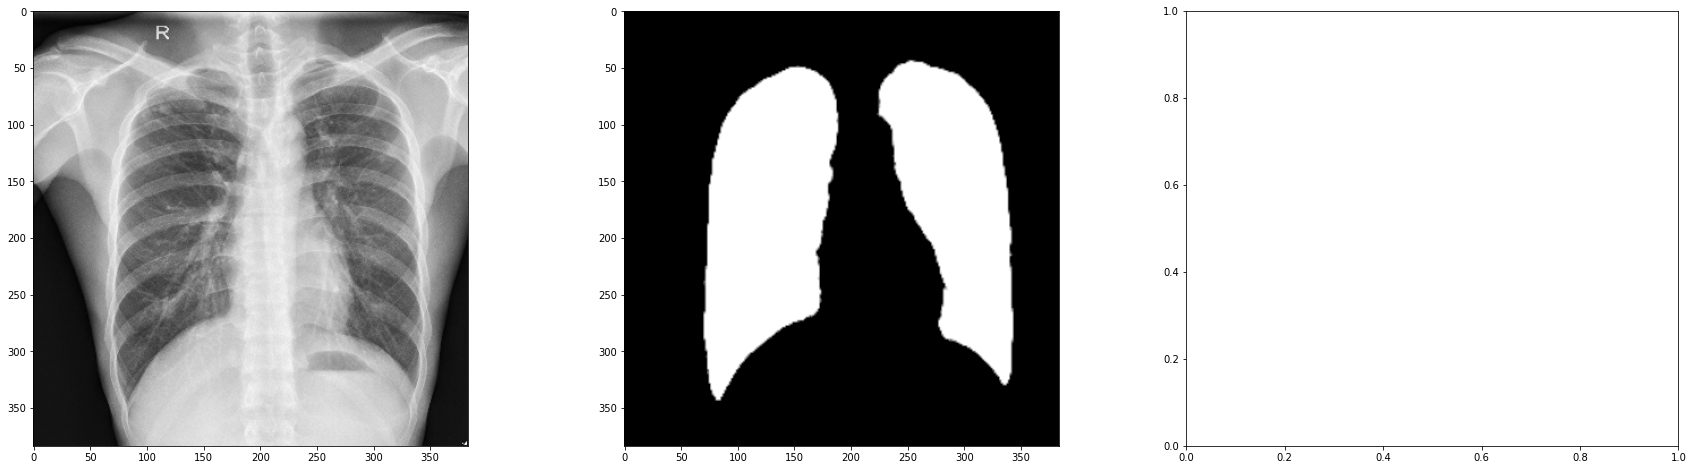

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


In [ ]:
example = working_combined_df.iloc[np.random.randint(0,len(working_combined_df)),:]
img = read_image(example.path, ImageReadMode.RGB)
img = resize(img)
mask = read_image(example.masks, ImageReadMode.GRAY)
mask = resize(mask)
mask = threshold(mask)
fig, ax = plt.subplots(1,3,figsize = (30,8))
ax = ax.flatten()
ax[0].imshow(img[0,:], cmap = 'gray')
ax[1].imshow(mask[0,:], cmap = 'gray')
plt.show()
print(mask)

In [ ]:
def boundaries_lung(mask, margin = 20):
  # blank = torch.zeros((384,384))
  mask = read_image(mask, ImageReadMode.GRAY)
  mask = resize(mask)
  mask = threshold(mask)
  mask = mask[0,:]
  cols = mask.any(0).nonzero()
  rows = mask.any(1).nonzero()
  top = rows[0].item() - margin
  bottom = rows[-1].item() + margin + 3
  left = cols[0].item() - margin
  right = cols[-1].item() + margin
  # blank[top : bottom, left : right] = 1
  return [top, bottom, left, right]
# boundaries_lung(mask)

In [ ]:
boundaries_lung(combined_df.masks.values[0])

(27, 322, 35, 360)

In [ ]:
# combined_df['top'], combined_df['bottom'], combined_df['left'], combined_df['right'] = 0,0,0,0
# combined_df

In [ ]:
values = full_df['masks'].apply(boundaries_lung)
tops, bottoms, lefts, rights = [],[],[],[]
for val in values:
  tops.append(val[0])
  bottoms.append(val[1])
  lefts.append(val[2])
  rights.append(val[3])
full_df['top'] = tops
full_df['bottom'] = bottoms
full_df['left'] = lefts
full_df['right'] = rights

In [ ]:
working_vin_df

In [ ]:
full_df.to_csv('full_working_nih_df.csv')
!cp ./full_working_nih_df.csv ./drive/MyDrive/cxr/nih/full_working_nih_df.csv

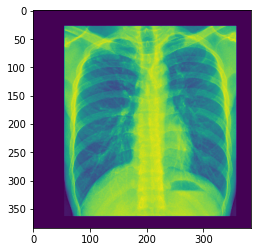

In [ ]:
# top, bottom, left, right = boundaries_lung(mask)
cxr_mask = boundaries_lung(mask)
img_masked = img * cxr_mask
# img = img[:,top : bottom, left : right]
# img = img[:,left : right, top : bottom]
plt.imshow(img_masked[0,:])

In [ ]:
all_strings = '|'.join(working_vin_df.findings).split('|')
pd.Series(all_strings).value_counts()

In [ ]:
# mont_df = pd.read_csv('./montgomery/montgomery_metadata.csv')
# images_mont = {os.path.basename(x): x for x in 
#                    glob(os.path.join('./montgomery/', 'images','images', '*.png'))}
# mont_df['path'] = mont_df['study_id'].apply(images_mont.get)
# mont_df.rename(columns = {'study_id' : 'image_id'}, inplace = True)

# shen_df = pd.read_csv('./shenzhen/shenzhen_metadata.csv')
# images_shen = {os.path.basename(x): x for x in 
#                    glob(os.path.join('./shenzhen/', 'images','images', '*.png'))}
# shen_df['path'] = shen_df['study_id'].apply(images_shen.get)
# shen_df.rename(columns = {'study_id' : 'image_id','sex' : 'gender'}, inplace = True)

# combined_df = pd.concat((shen_df,mont_df))
# combined_df.rename(columns = {'findings' : 'label'}, inplace = True)

# def parse_tb_findings(label):
#   if label == 'normal':
#     return 'No Finding'
#   findings = ['Consolidation']
#   label = str(label).lower()
#   if 'pneumot' in label:
#     findings.append('Pneumothorax')
#   if 'atelec' in label:
#     findings.append('Atelectasis')
#   if 'effusion' in label:
#     findings.append('Effusion')
#   if 'fibr' in label or 'scar' in label or 'calc' in label:
#     findings.append('Fibrosis')
#   if 'copd' in label or 'emphy' in label:
#     findings.append('Emphysema')
#   return '|'.join(findings)

# combined_df['findings'] = combined_df.label.apply(parse_tb_findings)
# combined_df.drop(labels = 'label',axis = 1, inplace=True)
# combined_df['masks'] = './combined/masks/' + combined_df['image_id'] + '_mask.png'

In [ ]:
# combined_aux_df = pd.read_csv('./combined/tb_aux.csv')
# combined_aux_df.rename(columns = {'image_index' : 'image_id'}, inplace = True)
# working_combined_df = pd.merge(combined_df, combined_aux_df, on = 'image_id')

In [ ]:
# raw_df = pd.read_csv(BASE_FOLDER + '/nih/Data_entry_2017.csv')
# raw_df = raw_df.drop('Unnamed: 11', axis = 1)
# raw_df.columns = ['image_id','findings', 'f/u', 'pt_id',
#                   'age', 'gender', 'position',
#                   'Width','Height', 'x', 'y']

# all_image_paths = {os.path.basename(x): x for x in 
                  #  glob(os.path.join('.', 'images*', '*', '*.png'))}
# raw_df['path'] = raw_df['image_index'].map(all_image_paths.get)
                   
# print('Scans found:', len(all_image_paths), ', Total Headers', raw_df.shape[0])
# raw_df['masks'] = './masks_nih/masks/' + raw_df['image_id'] + '_mask.png'
# raw_df

In [ ]:
# raw_df = pd.read_csv(BASE_FOLDER + '/nih/predicted_full_nih.csv')
# aux_df = pd.read_csv(BASE_FOLDER + '/nih/predicted_full_nih.csv')
# full_df = pd.merge(raw_df, aux_df, on = 'image_id')

In [ ]:
# aux_df = pd.read_csv('./nih/predicted_full_nih.csv')
# aux_df = aux_df.iloc[:, 2:]
# full_df = pd.merge(raw_df, aux_df, how = 'inner', on = 'image_index')

##Main Shit

In [ ]:
vin_df = pd.read_csv('./vinbigdata/full_working_vin_df.csv')
tb_df = pd.read_csv('./combined/full_working_combined_df.csv')

working_df = pd.read_csv(BASE_FOLDER + '/nih/full_working_nih_df.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('./nih', 'images*', '*', '*.png'))}
working_df['path'] = working_df['image_id'].map(all_image_paths.get)

FileNotFoundError: ignored

In [ ]:
def standardise_df(df):
  working_df = df.copy()
  working_df['findings'] = working_df['findings'].str.replace('Infiltration','Consolidation')
  working_df['findings'] = working_df['findings'].str.replace('Pneumonia','Consolidation')
  working_df['findings'] = working_df['findings'].str.replace('Nodule/Mass','Mass')
  working_df['findings'] = working_df['findings'].str.replace('Nodule','Mass')
  working_df['findings'] = working_df['findings'].str.replace('Lung Opacity','Mass')
  working_df['findings'] = working_df['findings'].str.replace('Pulmonary fibrosis','Fibrosis')
  working_df['findings'] = working_df['findings'].str.replace('ILD','Fibrosis')
  working_df['findings'] = working_df['findings'].str.replace('Pleural effusion', 'Effusion')
  
  return working_df

In [ ]:
working_df = standardise_df(working_df)

NameError: ignored

In [ ]:
with open(BASE_FOLDER + '/updated_worst_cxr.txt', 'r') as f:
  worst_cxr = f.read().split('\n')
worst_cxr = worst_cxr[:-1]
worst_cxr = set(worst_cxr)
worst_cxr = np.array([*worst_cxr])
worst_cxr = worst_cxr.astype('int')

with open(BASE_FOLDER + '/updated_last_cxr.txt', 'r') as f:
  last_cxr = f.read().split('\n')
last_cxr = last_cxr[:-1]
last_cxr = set(last_cxr)
last_cxr = np.array([*last_cxr])
last_cxr = last_cxr.astype('int')

In [ ]:
# For Patients whose all the images were bad
num = 0
for sick_pt_id in worst_cxr:
  _df = working_df[working_df['pt_id'] == sick_pt_id]
  nf_cxr = _df[_df['findings'] == 'No Finding']
  f_cxr = _df[_df['findings'] != 'No Finding']
  nf_cxr_idx = nf_cxr.index.values
  all_findings = f_cxr['findings'].values
  all_findings = '|'.join(all_findings).split('|')
  all_findings = pd.Series(all_findings)
  n_findings = all_findings.size
  findings = all_findings.value_counts()
  
  # Percentage of labels out of all the findings
  perc_findings = findings / n_findings * 100

  mc_diseases = []
  for i,j in perc_findings.iteritems():
    if j > 20:
      mc_diseases.append(i)
      
  joined_disease = '|'.join(mc_diseases)
  for i in nf_cxr_idx:
    if len(mc_diseases) > 0:
      num += 1
      working_df.at[i, 'findings'] = joined_disease
    else:
      working_df.at[i, 'findings'] = 'No Finding'
print(num)

In [ ]:
# For the patients whose first no finding images were okay
i = 0
NUM_REVIEWED = 951
follow_up_patients = working_df['pt_id'].value_counts().index.values
reviewed_fu = set(follow_up_patients[:NUM_REVIEWED])
last_cxr_set = set(last_cxr)
worst_cxr_set = set(worst_cxr)
forward_fu = reviewed_fu - last_cxr_set
forward_fu = forward_fu - worst_cxr_set

for forward_pt in forward_fu:
  working_df = working_df.reset_index(drop = True)
  _df = working_df[working_df['pt_id'] == forward_pt]
  nf_cxr = _df[_df['findings'] == 'No Finding']
  idx = nf_cxr.index.values
  i += len(idx) - 1
  working_df = working_df.drop(index = idx[1:])

print(i)

In [ ]:
# For all patients whose last images were okay
i = 0
for last_pt in last_cxr:
  working_df = working_df.reset_index(drop = True)
  _df = working_df[working_df['pt_id'] == last_pt]
  nf_cxr = _df[_df['findings'] == 'No Finding']
  idx = nf_cxr.index.values[::-1]
  i += len(idx) - 1
  working_df = working_df.drop(index = idx[1:])
print(i)

In [ ]:
# working_df["Abnormal"] = working_df[PATHOLOGY_LIST].any(axis = 1).astype('float32')
# # PATHOLOGY_LIST.append('Abnormal')
# working_df

#####Dropping with the help of Lung Segmentation

In [ ]:
def show_grid_img_df(df):
  fig, ax = plt.subplots(4,4, figsize = (15,15))
  ax = ax.flatten()
  print('Length of df ', len(df))
  df = df.sample(frac = 1.)
  for i in range(16):
    img = process_img(df.path.values[i])
    ax[i].imshow(img, cmap = 'gray')
    ax[i].set_xlabel([])
    ax[i].set_ylabel([])
  plt.show()

In [ ]:
working_df = working_df.reset_index(drop = True)
nf_low_ctr = working_df[(working_df['ct_ratio'] < .24) & (working_df['findings'] == 'No Finding')]['position']
working_df = working_df.drop(index = nf_low_ctr.index)
working_df = working_df.reset_index(drop = True)
nf_low_cta = working_df[(working_df['ct_area'] < .17) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_cta.index)
working_df = working_df.reset_index(drop = True)
nf_high_ctr = working_df[(working_df['ct_ratio'] > .68) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_ctr.index)
working_df = working_df.reset_index(drop = True)
nf_high_cta = working_df[(working_df['ct_area'] > .68) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_cta.index)
working_df = working_df.reset_index(drop = True)
nf_low_lung_area = working_df[(working_df['area_ratio'] < .55) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_lung_area.index)
working_df = working_df.reset_index(drop = True)
nf_high_lung_area = working_df[(working_df['area_ratio'] > 1.85) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_lung_area.index)
working_df = working_df.reset_index(drop = True)
nf_high_vs = working_df[(working_df['vertical_span_ratio'] > 1.45) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_vs.index)
working_df = working_df.reset_index(drop = True)
nf_low_vs = working_df[(working_df['vertical_span_ratio'] < .65) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_vs.index)
working_df = working_df.reset_index(drop = True)
nf_low_cp_pos = working_df[(working_df['cp_rel_position'] < .7) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_cp_pos.index)
working_df = working_df.reset_index(drop = True)
nf_high_cp_pos = working_df[(working_df['cp_rel_position'] > 1.3) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_cp_pos.index)
working_df = working_df.reset_index(drop = True)
nf_low_hw = working_df[(working_df['height_width_ratio'] < .55) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_low_hw.index)
# working_df = working_df.reset_index(drop = True)
# nf_high_hw = working_df[(working_df['height_width_ratio'] > 1.5) & (working_df['findings'] == 'No Finding')]
working_df = working_df.reset_index(drop = True)
nf_high_cp_angle =  working_df[((working_df['left_cp_angle'] > 145) | (working_df['right_cp_angle'] > 145)) & (working_df['findings'] == 'No Finding')]
working_df = working_df.drop(index = nf_high_cp_angle.index)

###Cleaning Data

While cleaning the data we have to make sure that we first replace all the relevant values and only after that we drop them or we would have to unnecessarily have to change the indices

In [ ]:
old_people = working_df[working_df['age'] > 100]
for people in old_people.itertuples():
  if people.age == 0:
    age = 47
  else:
    age = working_df[working_df['pt_id'] == people.pt_id]['age'].min()
  working_df.at[people.Index, 'age'] = age

In [ ]:
working_df['No Findings'] = working_df['findings'].apply(lambda x: 0 if 'No Finding' in x else 1)
working_df = working_df.drop(['No Findings'], axis = 1)

###Constructing dataframes of all the specific diseases separately so that I'm able to oversample them accordingly

In [ ]:
for pathology in PATHOLOGY_LIST :
    working_df[pathology] = working_df['findings'].apply(lambda x: 1. if pathology in x else 0.)

In [ ]:
diseased_df = working_df[working_df['findings'] != 'No Finding']
diseases_dict = {}
for i in PATHOLOGY_LIST:
  _df = working_df.loc[working_df['findings'].str.contains(i, case = False)]
  diseases_dict.update({i:_df})

no_findings_df = working_df.loc[working_df['findings'] == 'No Finding']

In [ ]:
class_probabilities = []
for i in PATHOLOGY_LIST:
  class_probabilities.append(working_df.loc[:,i].sum() / len(working_df))
class_probabilities = np.array(class_probabilities, dtype = 'float32')
sns.barplot(x = PATHOLOGY_LIST, y = class_probabilities)
plt.xticks(rotation = 90)

In [ ]:
augmented_df = working_df.copy()
for disease_name, df in diseases_dict.items():
  df_len = len(df)
  if disease_name in ['Cardiomegaly','Emphysema','Edema','Fibrosis']:
    sample = df.sample(frac = 3,replace = True)
  elif disease_name in ['Pneumothorax','Mass',]:
    sample = df.sample(frac = 2.2, replace = True)
  elif disease_name in ['Effusion','Atelectasis']:
    sample = df.sample(frac = .6, replace = True)
  # else:
    # sample = df.sample(frac = 0.2, replace = True)
  augmented_df = pd.concat((augmented_df, sample), axis = 0)

In [ ]:
class_probabilities = []
for i in PATHOLOGY_LIST:
  class_probabilities.append(augmented_df.loc[:,i].sum() / len(augmented_df))
class_probabilities = np.array(class_probabilities, dtype = 'float32')
sns.barplot(x = PATHOLOGY_LIST, y = class_probabilities)
plt.xticks(rotation = 90)

In [ ]:
augmented_df = augmented_df.replace((np.inf, -np.inf), np.nan)
augmented_df = augmented_df.dropna(axis = 0)

In [ ]:
augmented_df = augmented_df.reset_index(drop = True)
hernia = augmented_df[augmented_df['findings'] == 'Hernia']
augmented_df = augmented_df.drop(index = hernia.index)

####Trying shit out

In [ ]:
imgs = working_df[working_df['findings'].str.contains('Consolidation')]['path'].values
fig, ax  = plt.subplots(5,5,figsize = (30,30))
ax = ax.flatten()
for i in range(25):
  img = np.random.choice(imgs)
  img = read_image(img, ImageReadMode.GRAY)
  ax[i].imshow(img[0], cmap = 'gray')

#Maybe Processing

####All the dropping

In [ ]:
follow_up_patients = working_df['pt_id'].value_counts().index.values

So that I dont forget, the following patients are the ones in which im seeing all the cases which were labeled No finding and among them I have realised that the ones in the first are the ones which have no finding and all the others are bad.

In bekar_id all the xrays seem to be bad, and I can either discard the no findings of these or change them into the findings there are in the counter part.

In last good, the last of the xrays are better and jsut have to -1 for them

Remember that even for the ones whose inital cxr are fine, we can also go and check if we can get some relevant cxr to our problem514

did cases till 550

In [ ]:
i = 922

In [ ]:
def open_cxr_file(file):
  with open(file, 'r') as f:
    open_cxr = f.read().split('\n')
  open_cxr = open_cxr[:-1]
  open_cxr = set(open_cxr)
  open_cxr = np.array([*open_cxr])
  open_cxr = open_cxr.astype('int')
  return open_cxr

In [ ]:
last_cxr_file = BASE_FOLDER + '/updated_last_cxr.txt'
with open(last_cxr_file, 'a') as f:
      f.write(str(patient_id)+'\n')
last_cxr = open_cxr_file(last_cxr_file)

In [ ]:
worst_cxr_file = BASE_FOLDER + '/updated_worst_cxr.txt'
with open(worst_cxr_file, 'a') as f:
      f.write(str(patient_id)+'\n')
worst_cxr = open_cxr_file(worst_cxr_file)

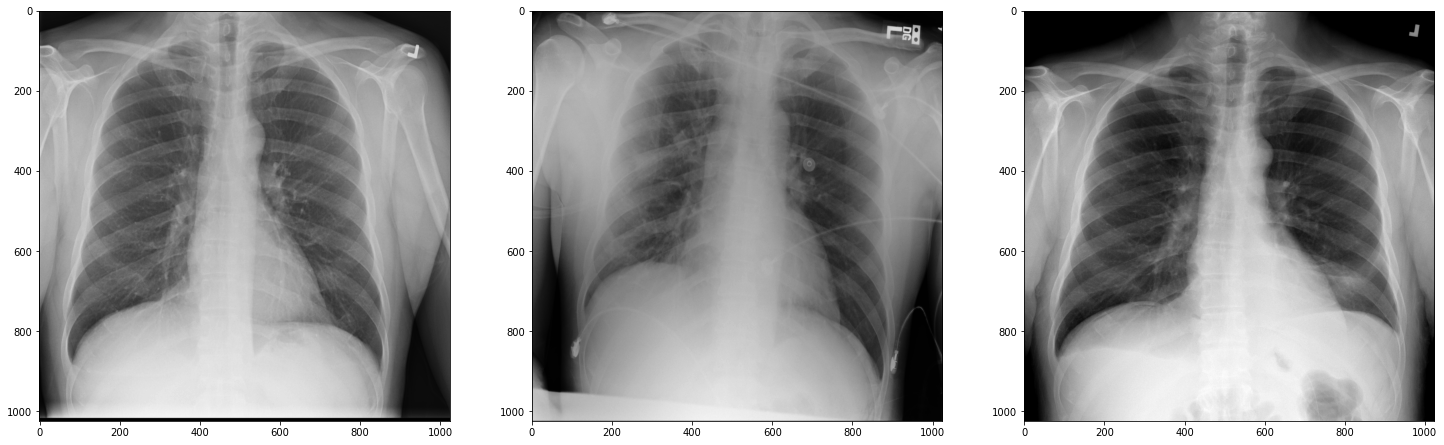

total cxr 16
normal cxr 7
patient_id 14355
Current_index 952
Different Diseases => 
 Effusion                                            5
Atelectasis                                         1
Atelectasis|Consolidation                           1
Atelectasis|Effusion|Consolidation                  1
Atelectasis|Consolidation|Effusion|Consolidation    1
Name: findings, dtype: int64


In [ ]:
well = working_df[working_df['pt_id'] == follow_up_patients[i]]
all_cxr = len(well)
no_finding_cxr = len(well[well['findings'] == 'No Finding'])
finding_cxr = well[well['findings'] != 'No Finding']['findings'].value_counts()

try:
  wellwell = well[well['findings'] == 'No Finding']['path'].values[0]
  wellwellmiddle = well[well['findings'] == 'No Finding']['path'].values[no_finding_cxr // 2]
  wellwelllast = well[well['findings'] == 'No Finding']['path'].values[-1]
  fig, ax = plt.subplots(1,3, figsize = (25,12))
  patient_id = follow_up_patients[i]
  ax[0].imshow(read_image(wellwell)[0,:], cmap = 'gray')
  ax[1].imshow(read_image(wellwellmiddle)[0,:], cmap = 'gray')
  ax[2].imshow(read_image(wellwelllast)[0,:], cmap = 'gray')
  plt.show()
  print('total cxr',len(well))
  print('normal cxr',no_finding_cxr)
  print('patient_id',patient_id)
  print('Current_index',i)
  print('Different Diseases => \n',finding_cxr)
  already = patient_id in [*worst_cxr, *last_cxr]
  print('already seen this patient') if already else None
  i += 1
except IndexError as e:
  print("No normal xrays")
  i += 1


In [ ]:
sick_pt_id = worst_cxr[np.random.randint(0,len(worst_cxr))]
_df = working_df[working_df['pt_id'] == 12880]
nf_cxr = _df[_df['findings'] == 'No Finding']
f_cxr = _df[_df['findings'] != 'No Finding']
n = len(_df)
nf_n = len(nf_cxr)
f_n = len(f_cxr)

print('Total Cxr = {}, nf_cxr = {}, f_cxr = {}, Percentage NF = {:.2f}%  '.format(n, nf_n, f_n, nf_n / n * 100) )
all_findings = f_cxr['findings'].values
all_findings = '|'.join(all_findings).split('|')
all_findings = pd.Series(all_findings)
n_findings = all_findings.size
findings = all_findings.value_counts()
perc_findings = findings / n_findings * 100
print('Total Number of Findings = ', n_findings)
pd.concat((perc_findings, findings), axis = 1)

In [ ]:
temp_df = nf_cxr.sample(frac = 1)
x = 25
fig, ax = plt.subplots(3,3,figsize = (x,x))
ax = ax.flatten()
for i in range(9):
  img = temp_df['path'].values[i]
  pos = temp_df['position'].values[i]
  finding = temp_df['findings'].values[i]
  img = process_img(img)
  ax[i].imshow(img, cmap  = 'gray')
  ax[i].set_title((pos, finding))
  ax[i].axis('off')
plt.tight_layout()

#### I can maybe get out all the auto correlation of the different labels to see what are the chances of  a few diseasesa occuring together

#Making Dataset

###Dataset

In [ ]:
class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

random_transforms = torch.nn.Sequential(
    T.RandomAutocontrast(0.2), 
    T.RandomAffine(
        degrees = 15,
        translate =  (.09,.09),
        scale = (.86, 1.20),
        shear =  9
    ),
    AddGaussianNoise(0,0.013)
)

In [ ]:
class CustomCXRDataset(Dataset):
  def __init__(self, df, transform = None, numeric_means = None,numeric_stds = None, if_isolate_lung = False):
    self.img_path = df.path.values
    self.labels = torch.Tensor(df.loc[:,PATHOLOGY_LIST].values)
    self.numeric_means = numeric_means
    self.numeric_stds = numeric_stds
    self.numeric_data = self.normalized_numeric_data(torch.Tensor(df.loc[:,numerical_cols].values))
    self.transform = transform
    self.resize = Resize((IMG_SIZE[:2]))
    self.top, self.bottom, self.left, self.right = df.top.values, df.bottom.values, df.left.values, df.right.values
    self.if_isolate_lung = if_isolate_lung
    self.img_mean = 129.489
    self.img_std = 59.339

  def normalized_numeric_data(self, data):
    if self.numeric_means != None or self.numeric_stds != None:
      return (data - self.numeric_means) / self.numeric_stds
    means = data.mean(0)
    stds = data.std(0)
    assert len(means) == data.shape[-1]
    numeric_data = (data - means) / stds
    self.numeric_means = means
    self.numeric_stds = stds
    self.resize = nn.Sequential(
        T.Resize(IMG_SIZE[:2],),
        T.Normalize(mean=[129.489,129.489 ,129.489,], std = [59.339,59.339,59.339,])
    )
    return numeric_data

  # def normalize_image(self, imgs):


  def isolate_lung(self, img, idx):
    mask = torch.zeros((IMG_SIZE[:2]))
    top = max(self.top[idx], 0)
    bottom = min(self.bottom[idx], IMG_SIZE[0])
    left = max(self.left[idx], 0)
    right = min(self.right[idx], IMG_SIZE[0])
    mask[top : bottom, left : right] = 1
    return img *  mask

  def __len__(self):
    return len(self.img_path)

  def __getitem__(self, idx):
    image = read_image(self.img_path[idx], ImageReadMode.RGB)
    image = image.type(torch.float32)
    image = self.resize(image)
    image = self.isolate_lung(image, idx) if self.if_isolate_lung else image
    label = self.labels[idx]
    numeric = self.numeric_data[idx]
    image = self.transform(image) if self.transform else image
    return image, numeric, label

In [ ]:
class CustomCXRDataset(Dataset):
  def __init__(self, df, transform = None, numeric_means = None,numeric_stds = None, if_isolate_lung = False):
    self.img_path = df.path.values
    self.labels = torch.Tensor(df.loc[:,PATHOLOGY_LIST].values)
    self.numeric_means = numeric_means
    self.numeric_stds = numeric_stds
    self.numeric_data = self.normalized_numeric_data(torch.Tensor(df.loc[:,numerical_cols].values))
    self.transform = transform
    self.resize = Resize((IMG_SIZE[:2]))
    self.top, self.bottom, self.left, self.right = df.top.values, df.bottom.values, df.left.values, df.right.values
    self.if_isolate_lung = if_isolate_lung
    self.img_mean = 129.489
    self.img_std = 59.339

  def normalized_numeric_data(self, data):
    if self.numeric_means != None or self.numeric_stds != None:
      return (data - self.numeric_means) / self.numeric_stds
    means = data.mean(0)
    stds = data.std(0)
    assert len(means) == data.shape[-1]
    numeric_data = (data - means) / stds
    self.numeric_means = means
    self.numeric_stds = stds
    self.resize = nn.Sequential(
        T.Resize(IMG_SIZE[:2],),
        T.Normalize(mean=[129.489], std = [59.339])
    )
    return numeric_data

  # def normalize_image(self, imgs):


  def isolate_lung(self, img, idx):
    mask = torch.zeros((IMG_SIZE[:2]))
    top = max(self.top[idx], 0)
    bottom = min(self.bottom[idx], IMG_SIZE[0])
    left = max(self.left[idx], 0)
    right = min(self.right[idx], IMG_SIZE[0])
    mask[top : bottom, left : right] = 1
    return img *  mask

  def __len__(self):
    return len(self.img_path)

  def __getitem__(self, idx):
    image = read_image(self.img_path[idx], ImageReadMode.GRAY)
    image = image.type(torch.float32)
    image = self.resize(image)
    image = torch.cat((image,image,image))
    image = self.isolate_lung(image, idx) if self.if_isolate_lung else image
    label = self.labels[idx]
    numeric = self.numeric_data[idx]
    image = self.transform(image) if self.transform else image
    return image, numeric, label

In [ ]:
vin_df = standardise_df(vin_df)
tb_df = standardise_df(tb_df)
for pathology in PATHOLOGY_LIST :
    vin_df[pathology] = vin_df['findings'].apply(lambda x: 1. if pathology in x else 0.)
    tb_df[pathology] = tb_df['findings'].apply(lambda x: 1. if pathology in x else 0.)

In [ ]:
from sklearn.model_selection import train_test_split
BATCH_SIZE = 32

CURRENT_DF = augmented_df

train_df, _interim_df = train_test_split(CURRENT_DF, test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(_interim_df, test_size=0.4, random_state = SEED)

# Can add more datsets into here
train_df = pd.concat((train_df, vin_df, tb_df))

train_ds = CustomCXRDataset(train_df, transform = random_transforms, if_isolate_lung=False)
val_ds = CustomCXRDataset(val_df, transform = False, numeric_means = train_ds.numeric_means, numeric_stds = train_ds.numeric_stds,if_isolate_lung=False)
test_ds = CustomCXRDataset(test_df, transform = False,numeric_means = train_ds.numeric_means, numeric_stds = train_ds.numeric_stds,if_isolate_lung=False)

train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, pin_memory=True, num_workers=8, prefetch_factor=  6)
val_dataloader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False,pin_memory = True,num_workers=8, prefetch_factor = 6)
test_dataloader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False,num_workers=8 )

In [ ]:
imgs, numeric,labels = next(iter(train_dataloader))
fig, ax = plt.subplots(3,3,figsize = (20,20))
ax = ax.flatten()
for i in range(9):
  ax[i].imshow(imgs[i,0,:,:], cmap = 'gray')
  ax[i].set_title(numeric[i][:2])

##Model

In [ ]:
feature_extractor = models.efficientnet_b6(pretrained = True)

aux_data_nn = nn.Sequential(
    nn.Linear(len(numerical_cols), len(numerical_cols)),
    nn.SiLU(),
)

conv_net = nn.Sequential(
    feature_extractor.features,
    nn.AdaptiveAvgPool2d(1),
)
feature_extractor.classifier[-1]

In [ ]:
!pip install validators
!pip install timm==0.5.4
model_type = "GPUNet-0" # select one from above
precision = "fp32" # select either fp32 of fp16 (for better performance on GPU)

gpunet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_gpunet', pretrained=True, model_type=model_type, model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# gpunet.to(device)
# gpunet.eval()

In [ ]:
aux_data_nn = nn.Sequential(
    nn.Linear(len(numerical_cols), len(numerical_cols)),
    nn.SiLU(),
)

# conv_net = nn.Sequential(
#     feature_extractor.features,
#     nn.AdaptiveAvgPool2d(1),
# )
gpunet.train()
conv_net = nn.Sequential(
    gpunet.network[:-1],
    nn.AdaptiveAvgPool2d(1),
)

In [ ]:
feeature_extractor = models.convnext_base(pretrained = True)

conv_net = nn.Sequential(
    feature_extractor.features,
    feature_extractor.avgpool
)
feature_extractor.classifier[-1]

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
class CXR_Net(nn.Module):
  def __init__(self):
    super(CXR_Net, self).__init__()
    self.conv_net = conv_net
    self.combined_seq = nn.Sequential(
        nn.Linear(2304 + len(numerical_cols), 512),
        nn.LeakyReLU(),
        nn.Linear(512, 512),
        nn.LeakyReLU(),
        nn.Linear(512, len(PATHOLOGY_LIST))
        )
    # self.numeric_line = aux_data_nn
    # self.img_mean = train_ds.img_mean
    # self.img_std = train_ds.img_std
    # self.numeric_means = train_ds.numeric_means
    # self.numeric_stds = train_ds.numeric_stds

  def forward(self, img, numeric):
    img_features = self.conv_net(img)
    size = img_features.shape
    img_features = img_features.view((size[0], size[1]))
    # numeric_features = self.numeric_line
    combined = torch.cat((img_features, numeric), 1)
    z = self.combined_seq(combined)
    return z

In [ ]:
pos_weights = np.sum(train_df.loc[:,PATHOLOGY_LIST].values, axis = 0) / len(train_df)
pos_weights = torch.tensor(pos_weights)
neg_weights = 1 - pos_weights
imratio = neg_weights / pos_weights
imratio = imratio.float().cuda()
imratio

tensor([11.1372, 13.4021,  3.9639,  7.4278,  5.8875,  3.4330, 10.4050,  2.5047,
        19.3169], device='cuda:0')

In [ ]:
state_dict = torch.load('./drive/MyDrive/Models/nih_full/b4_sgd_cropped_moment.pth')
model = CXR_Net()
model.load_state_dict(state_dict)
model = model.to(device)

In [ ]:
EPOCHS = 35
LEARNING_RATE = 1e-3
use_amp = True

model = CXR_Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE)
# optimizer = torch.optim.Adadelta(model.parameters(), )
loss_fn = nn.BCEWithLogitsLoss(pos_weight = imratio,reduction = 'sum').to(device)
scaler = torch.cuda.amp.grad_scaler.GradScaler(enabled=use_amp)
# lr_schedule = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
lr_schedule = torch.optim.lr_scheduler.MultiStepLR(optimizer, [15,25])

In [ ]:
configs.update(
    {
     'epochs' : EPOCHS,
     'init_lr' : LEARNING_RATE,
     'lr_schedule' : lr_schedule.state_dict,
     'mixed_precision' : use_amp,
     'architecture' : 'eff4',
     'loss' : loss_fn,
     'optimizer' : optimizer,
     'pos_weights' : imratio,
     'batch_size' : BATCH_SIZE,
    }
)

In [ ]:
def print_predictions( imgs,y_pred, y_true):
  i = np.random.randint(0,y_true.shape[0] - 1)

  true_label = [disease for label, disease in zip(y_true[i], PATHOLOGY_LIST) if label]
  true_label = true_label if len(true_label) > 0 else ['No Findings']
  true_label = '|'.join(true_label)
  sorted_pred = sorted([(disease, label.item()) for label, disease in zip(y_pred[i], PATHOLOGY_LIST)], key = lambda x : x[1], reverse = True)
  pred = {disease : label.item() for label, disease in zip(y_pred[i], PATHOLOGY_LIST)}
  img = imgs[i]

  print("True Label is ", true_label)
  print("Prediction is ", sorted_pred)

  return img, pred, true_label

def calc_auc_prc(preds, true):
  true, preds = true.cpu().detach(), preds.cpu().detach()
  weighted_prc_score = metrics.average_precision_score(true, preds, average = 'weighted')
  weighted_auc_score = metrics.roc_auc_score(true, preds, average = 'weighted')
  return weighted_auc_score, weighted_prc_score

def individual_prc_scores(preds, true, job_type = 'train'):
  true, preds = true.cpu().detach(), preds.cpu().detach()
  individual_prc_score = metrics.average_precision_score(true, preds, average = None)
  individual_prc_score = {f'{job_type}_{disease}' : score for disease, score in zip(PATHOLOGY_LIST, individual_prc_score)}
  print(individual_prc_score)
  wandb.log(individual_prc_score)

In [ ]:
def save_auc(y_true, y_preds):
  fig = plt.figure(figsize = (15,15))
  for i in range(len(PATHOLOGY_LIST)):
    fpr, tpr , _ = metrics.roc_curve(y_true[:,i], y_preds[:,i])
    score = metrics.roc_auc_score(y_true[:,i], y_preds[:,i])
    plt.plot(fpr, tpr, label = f'{PATHOLOGY_LIST[i]} - {score:.4f}')
    plt.legend()
  wandb.log({'auc_curve' : fig})

def save_prc(y_true, y_preds):
  precision = {}
  recall = {}
  average_precision = {}
  fig = plt.figure(figsize =( 15,15))
  for i, disease in enumerate(PATHOLOGY_LIST):
    precision[disease], recall[disease], thresh = metrics.precision_recall_curve(y_true[:,i], y_preds[:,i])
    average_precision[disease] = metrics.average_precision_score(y_true[:,i], y_preds[:,i])
    plt.plot(recall[disease], precision[disease], label = f'{disease} - {average_precision[disease]:.4f}')
    plt.legend()
    # plt.title(f'PRC Curve - {wandb.run.name} ')
  wandb.log({'prc_curve' : fig})

def read_torch_img(file):
  img = read_image(file).float()
  img /= 255.
  resize = T.Resize(IMG_SIZE[:2])
  img = resize(img)
  return img[None,:]

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, lr_scheduler, logging_freq = 200):
  global lr
  total_samples = len(dataloader.dataset)
  model.train()
  cum_test = None
  cum_preds = None
  LOGGING_FREQ = logging_freq
  avg_loss = []
  avg_prc = []
  for batch, (img,numeric_data,true_labels) in enumerate(dataloader):
    img,numeric_data,true_labels=img.to(device),numeric_data.to(device),true_labels.to(device)
    if batch % LOGGING_FREQ == 0: batch_start = perf_counter()

    with torch.cuda.amp.autocast(enabled = use_amp):
      pred = model(img, numeric_data)
      loss = loss_fn(pred, true_labels)
    # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
    scaler.scale(loss).backward()

    # scaler.step() first unscales the gradients of the optimizer's assigned params.
    # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
    # otherwise, optimizer.step() is skipped.
    scaler.step(optimizer)

    # Updates the scale for neimgt iteration.
    scaler.update()

    optimizer.zero_grad(set_to_none = True)

    if batch % LOGGING_FREQ == 0:
      time_per_batch = (perf_counter() - batch_start)
      loss, current = loss.item(), batch * len(img)
      avg_loss.append(loss)
      wandb.log({'train_loss' : np.mean(avg_loss)}, commit = False)
      print(f"loss: {np.mean(avg_loss):>7f}  [{current:>5d}/{total_samples:>5d}], Time/Batch: {time_per_batch:.3f}")
      
      if batch % (LOGGING_FREQ*5) == 0:
        cum_preds = pred if cum_preds == None else torch.cat((cum_preds, pred), axis = 0,)
        cum_test = true_labels if cum_test == None else torch.cat((cum_test, true_labels), 0)
        try:
          auc, prc = calc_auc_prc(cum_preds, cum_test)
          individual_prc_scores(cum_preds, cum_test)
          avg_prc.append(prc)
          prc = np.mean(avg_prc)
          print(f'Weighted AUC = {auc:.4f}, Weighted PRC = {prc:.4f}')
          wandb.log({'auc' : auc, 'prc' : prc}, commit = False)
        except ValueError:
          print('Value Error, passing ...')
        except TypeError:
          print('Type Erro, passisng')

  if lr_scheduler:
    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
  wandb.log({'lr' : lr}, commit  = False)

  

def val_loop(dataloader, model, loss_fn, save = True):
  global eval_metric
  total_samples = len(dataloader.dataset)
  model.eval()
  loss = 0

  cum_test = None
  cum_preds = None
  avg_loss = []
  for batch, (imgs,numeric_data, true_labels) in enumerate(dataloader):
    imgs,numeric_data,true_labels=imgs.to(device),numeric_data.to(device),true_labels.to(device)

    with torch.no_grad():
      preds = model(imgs, numeric_data)
      loss += loss_fn(preds, true_labels)

    cum_preds = preds if cum_preds == None else torch.cat((cum_preds, preds), axis = 0,)
    cum_test = true_labels if cum_test == None else torch.cat((cum_test, true_labels), 0)

  # Calculating Metrics
  try:
    auc, prc = calc_auc_prc(cum_preds, cum_test)
    individual_prc_scores(cum_preds, cum_test, job_type = 'val')

    print(f'Weighted AUC = {auc:.4f}, Weighted PRC = {prc:.4f} ')
    wandb.log({'val_auc' : auc, 'val_prc' : prc}, commit = False)
  except ValueError as e:
    print('Welp seems something happend')
    
  # Getting the loss
  loss = loss / (batch + 1)
  loss = loss.item()
  wandb.log({'val_loss' : loss}, commit = False)
  print(f"loss: {loss:>7f}")

  # Getting PRedictions
  img,pred,true_label = print_predictions( imgs, preds, true_labels)
  img,pred,true_label = print_predictions( imgs, preds, true_labels)
  if epoch > 5:
    table.add_data(epoch, wandb.Image(img), true_label, pred)

  if prc > eval_metric:
    eval_metric = prc
    print('Best Model Yet !!!')
    run_name = run.name
    if save : 
      print('Saving Model')
      torch.save(model.state_dict(), f'./{run_name}.pth')
      os.system(f'cp ./{run_name}.pth ./drive/MyDrive/Models/nih_full/{run_name}.pth')



def test_loop(dataloader, model):
  test_preds = torch.Tensor().to(device)
  test_labels = torch.Tensor().to(device)
  model.eval()
  for img, numeric_data,labels in dataloader:
    img,numeric_data,labels=img.to(device),numeric_data.to(device),labels.to(device)
    with torch.no_grad():

      preds = model(img,numeric_data)
      test_preds = torch.cat((test_preds, preds), 0)
      test_labels = torch.cat((test_labels, labels), 0)

  y_true, y_preds = test_labels.cpu() ,test_preds.cpu()
  save_auc(y_true, y_preds)
  save_prc(y_true, y_preds)

  # custom_cxr = wandb.Table(columns = ['image', 'predictions'])
  # TB_CXR = './drive/MyDrive/tb_ambala_cxr/'
  # cxrs = np.random.choice(os.listdir(TB_CXR), 30)
  # for cxr in cxrs:
  #   cxr = os.path.join(TB_CXR, cxr)
  #   img = read_torch_img(cxr)
  #   with torch.no_grad():
  #     img = img.cuda()
  #     pred = model(img)
  #   pred_dict = {disease:value.item() for disease, value in zip(PATHOLOGY_LIST, pred[0])}
  #   custom_cxr.add_data(wandb.Image(img[0]), pred_dict)
  # wandb.log({'custom_predictions' : custom_cxr})

In [ ]:
from time import perf_counter

with wandb.init(name = 'eff4_nest', project = 'nih_full_pytorch',group='Normalised',config=configs) as run:
  # wandb.watch(model, log_freq = 1000, log = 'all', log_graph = True,)
  table = wandb.Table(columns = ['epoch','image', 'label', 'prediction'], allow_mixed_types=True)
  eval_metric = 0
  lr = LEARNING_RATE
  for epoch in range(EPOCHS):
    wandb.log({'epoch' : epoch}, commit = False)
    start = perf_counter()

    print(f"Starting {epoch + 1} epoch \n-------------------------------- ")
    print('Learning Rate = ', lr)

    print('Starting Training \n---------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer, lr_schedule, 300)

    print('Validating \n---------------------')
    val_loop(val_dataloader, model, loss_fn, save = True)

    epoch_time =  perf_counter() - start

    wandb.log({'epoch_time' : epoch_time}, commit = True)
    print('Time taken => ',epoch_time)
    print('===================================\n')

  wandb.log({'predictions_table' : table})
  test_loop(test_dataloader, model)

Starting 1 epoch 
-------------------------------- 
Learning Rate =  0.001
Starting Training 
---------------------
loss: 335.393890  [    0/173344], Time/Batch: 4.187
{'train_Cardiomegaly': 0.27609427609427606, 'train_Emphysema': 0.07125000000000001, 'train_Effusion': 0.29952454952454954, 'train_Pneumothorax': 0.0685799035965888, 'train_Atelectasis': 0.20313025210084035, 'train_Mass': 0.26680678362161153, 'train_Edema': 0.07138377926421405, 'train_Consolidation': 0.493040293040293, 'train_Fibrosis': 0.25}
Weighted AUC = 0.5126, Weighted PRC = 0.2643
loss: 324.573502  [ 9600/173344], Time/Batch: 0.221
loss: 308.344493  [19200/173344], Time/Batch: 0.231
loss: 307.218460  [28800/173344], Time/Batch: 0.230
loss: 290.662378  [38400/173344], Time/Batch: 0.250
loss: 293.673599  [48000/173344], Time/Batch: 0.222
{'train_Cardiomegaly': 0.4015734989648033, 'train_Emphysema': 0.34880600750938673, 'train_Effusion': 0.47438903639173136, 'train_Pneumothorax': 0.2546042616131121, 'train_Atelectasis'

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 241.371056  [ 9600/173344], Time/Batch: 0.202
loss: 237.106186  [19200/173344], Time/Batch: 0.239
loss: 229.801479  [28800/173344], Time/Batch: 0.255
loss: 235.845462  [38400/173344], Time/Batch: 0.226
loss: 240.129321  [48000/173344], Time/Batch: 0.218
Value Error, passing ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 239.400042  [57600/173344], Time/Batch: 0.241
loss: 244.509338  [67200/173344], Time/Batch: 0.253
loss: 242.218994  [76800/173344], Time/Batch: 0.221
loss: 246.671921  [86400/173344], Time/Batch: 0.235
loss: 247.864086  [96000/173344], Time/Batch: 0.238
{'train_Cardiomegaly': 0.8055555555555556, 'train_Emphysema': 0.39959870752553683, 'train_Effusion': 0.5856417599778168, 'train_Pneumothorax': 0.6258658008658009, 'train_Atelectasis': 0.45668591524171576, 'train_Mass': 0.4783740596499362, 'train_Edema': 0.67989787989788, 'train_Consolidation': 0.6354498209520124, 'train_Fibrosis': 0.2808506866696522}
Weighted AUC = 0.7877, Weighted PRC = 0.5492
loss: 245.680185  [105600/173344], Time/Batch: 0.218
loss: 248.700457  [115200/173344], Time/Batch: 0.311
loss: 243.592789  [124800/173344], Time/Batch: 0.210
loss: 239.327698  [134400/173344], Time/Batch: 0.264
loss: 240.807076  [144000/173344], Time/Batch: 0.223
{'train_Cardiomegaly': 0.8055555555555556, 'train_Emphysema': 0.5803615619926

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 192.867928  [ 9600/173344], Time/Batch: 0.200
loss: 215.149012  [19200/173344], Time/Batch: 0.224
loss: 206.983982  [28800/173344], Time/Batch: 0.199
loss: 226.378214  [38400/173344], Time/Batch: 0.256
loss: 222.383214  [48000/173344], Time/Batch: 0.198
Value Error, passing ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 222.071956  [57600/173344], Time/Batch: 0.264
loss: 219.024590  [67200/173344], Time/Batch: 0.279
loss: 218.226532  [76800/173344], Time/Batch: 0.220
loss: 217.926486  [86400/173344], Time/Batch: 0.216
loss: 224.221927  [96000/173344], Time/Batch: 0.199
{'train_Cardiomegaly': 0.6154647435897436, 'train_Emphysema': 0.7691478869898807, 'train_Effusion': 0.5838111022598916, 'train_Pneumothorax': 0.7446148971194193, 'train_Atelectasis': 0.5465929298542389, 'train_Mass': 0.6067836132627018, 'train_Edema': 0.5348065531822013, 'train_Consolidation': 0.7135076547167756, 'train_Fibrosis': 0.4230769230769231}
Weighted AUC = 0.8378, Weighted PRC = 0.6368
loss: 218.967082  [105600/173344], Time/Batch: 0.205
loss: 225.313148  [115200/173344], Time/Batch: 0.234
loss: 227.817605  [124800/173344], Time/Batch: 0.235
loss: 231.120138  [134400/173344], Time/Batch: 0.244
loss: 235.067009  [144000/173344], Time/Batch: 0.236
{'train_Cardiomegaly': 0.5870989304812835, 'train_Emphysema': 0.6624158505135

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 170.135681  [ 9600/173344], Time/Batch: 0.221
loss: 169.125987  [19200/173344], Time/Batch: 0.239
loss: 164.671310  [28800/173344], Time/Batch: 0.234
loss: 170.814630  [38400/173344], Time/Batch: 0.268
loss: 170.039591  [48000/173344], Time/Batch: 0.245
{'train_Cardiomegaly': 0.787037037037037, 'train_Emphysema': 0.3333333333333333, 'train_Effusion': 0.911024531024531, 'train_Pneumothorax': 0.7954326923076923, 'train_Atelectasis': 0.4428272452185495, 'train_Mass': 0.6020833333333333, 'train_Edema': 0.8333333333333333, 'train_Consolidation': 0.692815801174837, 'train_Fibrosis': 0.7}
Weighted AUC = 0.8858, Weighted PRC = 0.6838
loss: 173.483287  [57600/173344], Time/Batch: 0.239
loss: 171.929537  [67200/173344], Time/Batch: 0.243
loss: 169.275296  [76800/173344], Time/Batch: 0.268
loss: 174.385939  [86400/173344], Time/Batch: 0.221
loss: 171.762380  [96000/173344], Time/Batch: 0.219
{'train_Cardiomegaly': 0.8511752136752136, 'train_Emphysema': 0.44365079365079363, 'train_Effusion':

wandb: Network error (ReadTimeout), entering retry loop.


loss: 150.548638  [134400/173344], Time/Batch: 0.240
loss: 152.046268  [144000/173344], Time/Batch: 0.228
{'train_Cardiomegaly': 0.7827651515151515, 'train_Emphysema': 0.7600881261595547, 'train_Effusion': 0.6610164916184712, 'train_Pneumothorax': 0.7072491397491396, 'train_Atelectasis': 0.5654048614292975, 'train_Mass': 0.6334941954522696, 'train_Edema': 0.9841597796143251, 'train_Consolidation': 0.5366741645017973, 'train_Fibrosis': 0.5497685185185185}
Weighted AUC = 0.8779, Weighted PRC = 0.6687
loss: 150.226251  [153600/173344], Time/Batch: 0.214
loss: 149.772603  [163200/173344], Time/Batch: 0.238
loss: 148.021085  [172800/173344], Time/Batch: 0.182
Validating 
---------------------
{'val_Cardiomegaly': 0.9330805614085415, 'val_Emphysema': 0.9358135401942026, 'val_Effusion': 0.811735198200196, 'val_Pneumothorax': 0.896553904776762, 'val_Atelectasis': 0.6937942535690438, 'val_Mass': 0.8133818106028405, 'val_Edema': 0.9704229109427708, 'val_Consolidation': 0.6969137428350256, 'val_F

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 145.151642  [ 9600/173344], Time/Batch: 0.246
loss: 137.537435  [19200/173344], Time/Batch: 0.231
loss: 128.690903  [28800/173344], Time/Batch: 0.247
loss: 129.481595  [38400/173344], Time/Batch: 0.235
loss: 124.436021  [48000/173344], Time/Batch: 0.261
{'train_Cardiomegaly': 0.8166666666666667, 'train_Emphysema': 0.875, 'train_Effusion': 0.9169996354980876, 'train_Pneumothorax': 0.9223671497584541, 'train_Atelectasis': 0.789090676348741, 'train_Mass': 0.8720977412569539, 'train_Edema': 1.0, 'train_Consolidation': 0.7695422460128342, 'train_Fibrosis': 0.225}
Weighted AUC = 0.9483, Weighted PRC = 0.8519
loss: 130.417861  [57600/173344], Time/Batch: 0.204
loss: 130.310311  [67200/173344], Time/Batch: 0.225
loss: 127.573601  [76800/173344], Time/Batch: 0.285
loss: 129.806701  [86400/173344], Time/Batch: 0.224
loss: 133.738458  [96000/173344], Time/Batch: 0.237
{'train_Cardiomegaly': 0.8972222222222223, 'train_Emphysema': 0.8999999999999999, 'train_Effusion': 0.8612822925478474, 'tra

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 159.353420  [ 9600/173344], Time/Batch: 0.253
loss: 145.259679  [19200/173344], Time/Batch: 0.224
loss: 141.664322  [28800/173344], Time/Batch: 0.308
loss: 141.948862  [38400/173344], Time/Batch: 0.266
loss: 146.939987  [48000/173344], Time/Batch: 0.246
{'train_Cardiomegaly': 0.770439084724799, 'train_Emphysema': 0.45, 'train_Effusion': 0.7873890738233496, 'train_Pneumothorax': 0.8289862914862915, 'train_Atelectasis': 0.6177243021866548, 'train_Mass': 0.704861111111111, 'train_Edema': 1.0, 'train_Consolidation': 0.5062972790886139, 'train_Fibrosis': 0.7976190476190476}
Weighted AUC = 0.8965, Weighted PRC = 0.7082
loss: 149.747731  [57600/173344], Time/Batch: 0.205
loss: 146.875376  [67200/173344], Time/Batch: 0.224
loss: 145.687025  [76800/173344], Time/Batch: 0.222
loss: 140.397098  [86400/173344], Time/Batch: 0.248
loss: 139.115451  [96000/173344], Time/Batch: 0.212
{'train_Cardiomegaly': 0.7947115384615385, 'train_Emphysema': 0.6916666666666667, 'train_Effusion': 0.70783177997

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 113.729942  [ 9600/173344], Time/Batch: 0.260
loss: 120.994466  [19200/173344], Time/Batch: 0.220
loss: 128.981297  [28800/173344], Time/Batch: 0.234
loss: 134.387650  [38400/173344], Time/Batch: 0.225
loss: 133.516162  [48000/173344], Time/Batch: 0.228
{'train_Cardiomegaly': 0.75, 'train_Emphysema': 1.0, 'train_Effusion': 0.9332467532467531, 'train_Pneumothorax': 0.9447368421052631, 'train_Atelectasis': 0.7, 'train_Mass': 0.7722732067768833, 'train_Edema': 0.9821428571428572, 'train_Consolidation': 0.7770872545329067, 'train_Fibrosis': 0.698051948051948}
Weighted AUC = 0.9470, Weighted PRC = 0.8516
loss: 130.891835  [57600/173344], Time/Batch: 0.245
loss: 129.537906  [67200/173344], Time/Batch: 0.206
loss: 129.526176  [76800/173344], Time/Batch: 0.232
loss: 128.475320  [86400/173344], Time/Batch: 0.212
loss: 128.530259  [96000/173344], Time/Batch: 0.207
{'train_Cardiomegaly': 0.8921568627450981, 'train_Emphysema': 0.9704861111111112, 'train_Effusion': 0.8878638541265957, 'train_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 113.757843  [ 9600/173344], Time/Batch: 0.249
loss: 106.385541  [19200/173344], Time/Batch: 0.239
loss: 115.468283  [28800/173344], Time/Batch: 0.206
loss: 120.526994  [38400/173344], Time/Batch: 0.234
loss: 126.236469  [48000/173344], Time/Batch: 0.221
{'train_Cardiomegaly': 0.8928571428571428, 'train_Emphysema': 0.9111111111111112, 'train_Effusion': 0.9556213017751478, 'train_Pneumothorax': 0.9412337662337663, 'train_Atelectasis': 0.8184523809523809, 'train_Mass': 0.657223892681915, 'train_Edema': 1.0, 'train_Consolidation': 0.4436101318463708, 'train_Fibrosis': 0.8541666666666666}
Weighted AUC = 0.9196, Weighted PRC = 0.7797
loss: 133.883265  [57600/173344], Time/Batch: 0.218
loss: 129.410506  [67200/173344], Time/Batch: 0.235
loss: 130.407007  [76800/173344], Time/Batch: 0.232
loss: 127.282249  [86400/173344], Time/Batch: 0.243
loss: 126.535622  [96000/173344], Time/Batch: 0.208
{'train_Cardiomegaly': 0.8928571428571428, 'train_Emphysema': 0.876984126984127, 'train_Effusion':

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 130.855774  [ 9600/173344], Time/Batch: 0.244
loss: 129.095418  [19200/173344], Time/Batch: 0.249
loss: 126.556198  [28800/173344], Time/Batch: 0.251
loss: 119.942461  [38400/173344], Time/Batch: 0.246
loss: 113.679701  [48000/173344], Time/Batch: 0.268
{'train_Cardiomegaly': 0.7892857142857144, 'train_Emphysema': 0.976190476190476, 'train_Effusion': 0.9350906037472193, 'train_Pneumothorax': 0.8501683501683501, 'train_Atelectasis': 0.9325396825396826, 'train_Mass': 0.8261266742149851, 'train_Edema': 0.9166666666666666, 'train_Consolidation': 0.8563294577226468, 'train_Fibrosis': 1.0}
Weighted AUC = 0.9496, Weighted PRC = 0.8829
loss: 118.101073  [57600/173344], Time/Batch: 0.203
loss: 121.762393  [67200/173344], Time/Batch: 0.201
loss: 122.016276  [76800/173344], Time/Batch: 0.200
loss: 120.980090  [86400/173344], Time/Batch: 0.257
loss: 118.813683  [96000/173344], Time/Batch: 0.204
{'train_Cardiomegaly': 0.8927128427128428, 'train_Emphysema': 0.9583333333333334, 'train_Effusion'

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 128.307228  [ 9600/173344], Time/Batch: 0.204
loss: 126.421466  [19200/173344], Time/Batch: 0.205
loss: 131.900801  [28800/173344], Time/Batch: 0.203
loss: 129.605820  [38400/173344], Time/Batch: 0.270
loss: 127.733901  [48000/173344], Time/Batch: 0.231
Value Error, passing ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 126.583821  [57600/173344], Time/Batch: 0.218
loss: 129.395300  [67200/173344], Time/Batch: 0.221
loss: 128.929977  [76800/173344], Time/Batch: 0.266
loss: 126.044029  [86400/173344], Time/Batch: 0.230
loss: 130.011870  [96000/173344], Time/Batch: 0.254
{'train_Cardiomegaly': 0.6388888888888888, 'train_Emphysema': 1.0, 'train_Effusion': 0.7758376466545618, 'train_Pneumothorax': 0.7631124379576391, 'train_Atelectasis': 0.86009478726584, 'train_Mass': 0.79607016797365, 'train_Edema': 0.8958944281524928, 'train_Consolidation': 0.6985627862393748, 'train_Fibrosis': 1.0}
Weighted AUC = 0.9249, Weighted PRC = 0.8022
loss: 129.158098  [105600/173344], Time/Batch: 0.224
loss: 131.523990  [115200/173344], Time/Batch: 0.213
loss: 131.979737  [124800/173344], Time/Batch: 0.235
loss: 130.393657  [134400/173344], Time/Batch: 0.248
loss: 131.073771  [144000/173344], Time/Batch: 0.227
{'train_Cardiomegaly': 0.6791666666666667, 'train_Emphysema': 0.8734126984126983, 'train_Effusion': 0.737267236

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 130.425331  [ 9600/173344], Time/Batch: 0.220
loss: 139.439662  [19200/173344], Time/Batch: 0.199
loss: 132.027809  [28800/173344], Time/Batch: 0.217
loss: 129.352814  [38400/173344], Time/Batch: 0.271
loss: 129.148369  [48000/173344], Time/Batch: 0.213
{'train_Cardiomegaly': 1.0, 'train_Emphysema': 0.8611111111111112, 'train_Effusion': 0.7175045630889823, 'train_Pneumothorax': 0.9083333333333332, 'train_Atelectasis': 0.5321789321789321, 'train_Mass': 0.7481434427086602, 'train_Edema': 0.9107142857142857, 'train_Consolidation': 0.8180184893733882, 'train_Fibrosis': 0.2}
Weighted AUC = 0.9254, Weighted PRC = 0.7914
loss: 128.624915  [57600/173344], Time/Batch: 0.269
loss: 129.263912  [67200/173344], Time/Batch: 0.247
loss: 127.258248  [76800/173344], Time/Batch: 0.222
loss: 123.376741  [86400/173344], Time/Batch: 0.231
loss: 121.766115  [96000/173344], Time/Batch: 0.208
{'train_Cardiomegaly': 0.9583333333333334, 'train_Emphysema': 0.8427197802197802, 'train_Effusion': 0.7232450228

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 122.557152  [ 9600/173344], Time/Batch: 0.204
loss: 134.604685  [19200/173344], Time/Batch: 0.241
loss: 127.236343  [28800/173344], Time/Batch: 0.291
loss: 131.250977  [38400/173344], Time/Batch: 0.247
loss: 131.620804  [48000/173344], Time/Batch: 0.303
{'train_Cardiomegaly': 1.0, 'train_Emphysema': 1.0, 'train_Effusion': 0.8197195464163789, 'train_Pneumothorax': 0.9129251700680272, 'train_Atelectasis': 0.9146031746031746, 'train_Mass': 0.9091839345949628, 'train_Edema': 1.0, 'train_Consolidation': 0.8823457084712777, 'train_Fibrosis': 0.8611111111111112}
Weighted AUC = 0.9455, Weighted PRC = 0.8990
loss: 124.728326  [57600/173344], Time/Batch: 0.223
loss: 124.112312  [67200/173344], Time/Batch: 0.277
loss: 121.438748  [76800/173344], Time/Batch: 0.206
loss: 122.283403  [86400/173344], Time/Batch: 0.230
loss: 125.284991  [96000/173344], Time/Batch: 0.238
{'train_Cardiomegaly': 0.9480519480519478, 'train_Emphysema': 0.9111111111111112, 'train_Effusion': 0.8471406481148529, 'train_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


loss: 126.391418  [ 9600/173344], Time/Batch: 0.245
loss: 129.656871  [19200/173344], Time/Batch: 0.355
loss: 127.953882  [28800/173344], Time/Batch: 0.202
loss: 126.828508  [38400/173344], Time/Batch: 0.203
loss: 125.897821  [48000/173344], Time/Batch: 0.203
{'train_Cardiomegaly': 1.0, 'train_Emphysema': 1.0, 'train_Effusion': 0.926699770817418, 'train_Pneumothorax': 0.6271464646464646, 'train_Atelectasis': 0.37283549783549785, 'train_Mass': 0.8134078474069414, 'train_Edema': 0.8333333333333333, 'train_Consolidation': 0.6766057498212743, 'train_Fibrosis': 1.0}
Weighted AUC = 0.8963, Weighted PRC = 0.7818
loss: 132.381451  [57600/173344], Time/Batch: 0.206
loss: 128.892483  [67200/173344], Time/Batch: 0.240
loss: 128.719474  [76800/173344], Time/Batch: 0.228
loss: 126.653386  [86400/173344], Time/Batch: 0.203
loss: 126.802436  [96000/173344], Time/Batch: 0.204
{'train_Cardiomegaly': 0.9444444444444444, 'train_Emphysema': 0.9166666666666665, 'train_Effusion': 0.9219940135301055, 'train_

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



auc,▁▄▆▆▆▆▆▇▇▇▇▇▇▇██▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇████▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch_time,▂▂▁▁▂▄▅▅▅▄▃▃▄▄▅▃▄▄▃▆▇█▅▆▅▆▇▆▆▆▅▆▅▆▃
prc,▁▂▅▅▇▆▆▆▇▇▇▆▆▇▇█▆▇▇▆▇▇█▇▇█▇█▇▇▆▆█████▇█▇
train_Atelectasis,▁▂▄▃▁▂▄▃▆▆▆▅▄▆▃▇▅▆▄▄▅▆▅▅▃▆▇▄▇▂▃▅▆▆█▇▆▅█▅
train_Cardiomegaly,▁▂▄▄█▄▇▇█▇▆▅▆▇▇▄▆▆██▇▆█▇▅▇▆█▆██▆▇▇████▇▇
train_Consolidation,▁▁▆▃▃▄▂▄▆▃▇▅▂▇▆▇▂▅▇▄▇▆▆█▆▅▅█▆▅▆▃▇▇▅▅▆▇▇▆
train_Edema,▁▄▄██▇▇▇▅████████▇▇▇▆▇█▇▇█▇▇▆▇███▇█▇█▇▇▇
train_Effusion,▁▄▄▃▇▅▅▇▆▇▅▅▅▇▇█▆▅▇▅▆▇▆▆▇▇▇█▇▅▃▅███▇▇▆▇█
train_Emphysema,▁▃▆▂▇▇▆▅▇▇██▆▇▇▆▄█▆▇▆▇████▇▆█▆█▆▇▇█▇▇▇▇▇
train_Fibrosis,▂▁▃▄█▁▄▄█▄█▅▄▅▅█▆▆█▆▆▆▇██▇▇▇▄▇██▇██▆▄▅▆█


ABle to plo these things easily now the plan is to delete the prior stuff, get a proper pipeline for interpretation and also testing all the data with a testing function at the end. Can put that in the finally section so that no matter what happens, the interpretation will be saved.

After that we can goa nd get onto the big bouys.

Also, see that the predictions made are coming out fine.


#Evaluation

In [ ]:
state_dict = torch.load('./drive/MyDrive/Models/nih_full/eff6_non_normalised_95prc.pth')
model = CXR_Net()
model.load_state_dict(state_dict)
model = model.to(device)

NameError: ignored

'0'

In [ ]:
# model = feature_extractor.cuda()
test_preds = torch.Tensor().to(device)
test_labels = torch.Tensor().to(device)
model = model.cuda()
for img, numeric_data, labels in test_dataloader:
  with torch.no_grad():
    img, numeric_data, labels = img.to(device),numeric_data.to(device), labels.to(device)
    preds = model(img, numeric_data)
    test_preds = torch.cat((test_preds, preds), 0)
    test_labels = torch.cat((test_labels, labels), 0)


In [ ]:
y_preds, y_true = test_preds.cpu().numpy(), test_labels.cpu().numpy()

In [ ]:
i = np.random.randint(0, len(test_ds))
y_preds[i], y_true[i]

(array([-7.5204697, -8.816667 ,  7.3082314, -3.6510108, -7.839009 ,
         1.418452 , -6.4790463, -1.3017951, -9.320643 ], dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32))

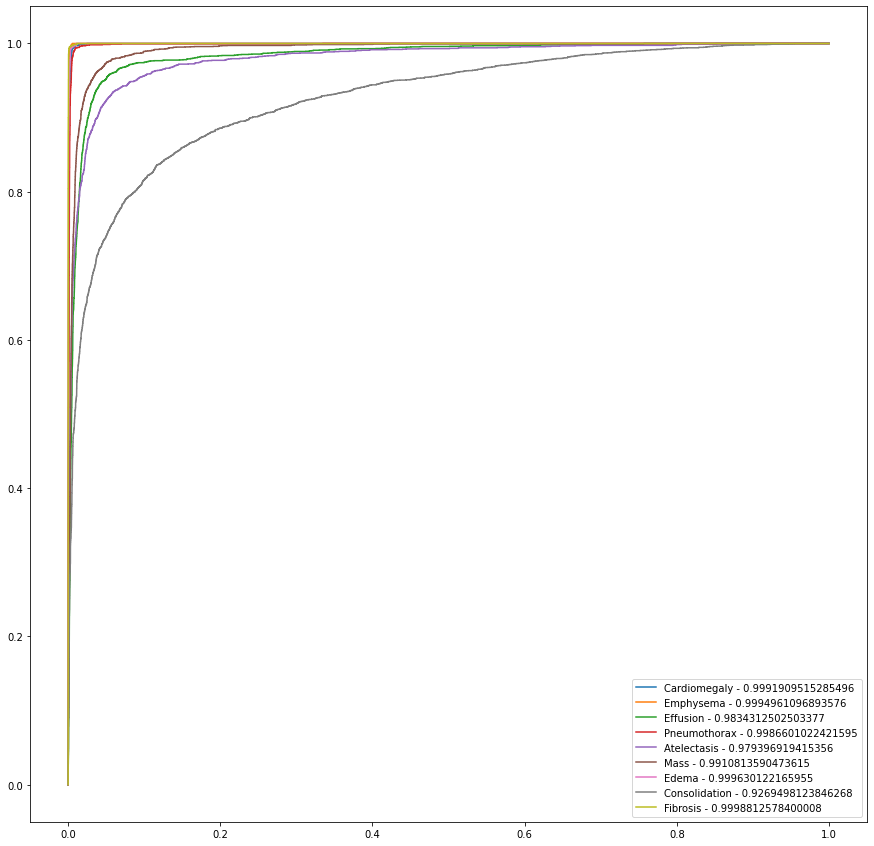

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
fig = plt.figure(figsize = (15,15))
for i in range(len(PATHOLOGY_LIST)):
  fpr, tpr , _ = roc_curve(y_true[:,i], y_preds[:,i])
  score = roc_auc_score(y_true[:,i], y_preds[:,i])
  plt.plot(fpr, tpr, label = f'{PATHOLOGY_LIST[i]} - {score}')
  plt.legend()

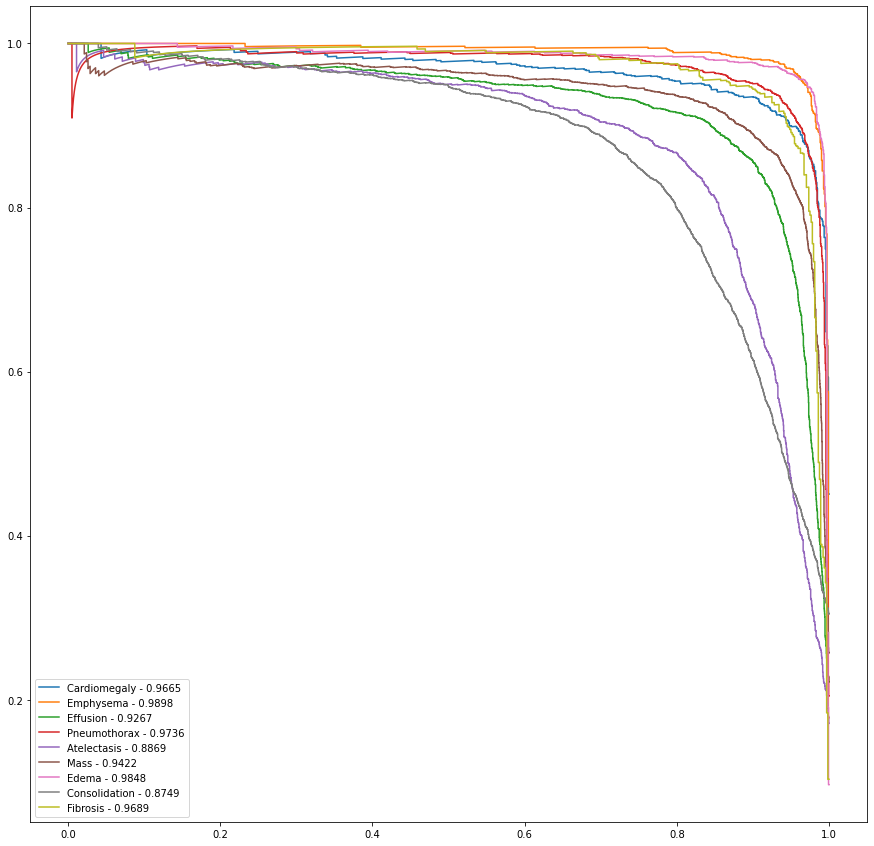

In [ ]:
precision = {}
recall = {}
thresh = {}
average_precision = {}
fig = plt.figure(figsize =( 15,15))
for i, disease in enumerate(PATHOLOGY_LIST):
  precision[disease], recall[disease], thresh[disease] = metrics.precision_recall_curve(y_true[:,i], y_preds[:,i])
  average_precision[disease] = metrics.average_precision_score(y_true[:,i], y_preds[:,i])
  plt.plot(recall[disease], precision[disease], label = f'{disease} - {average_precision[disease]:.4f}')
  plt.legend()
  # plt.title(f'PRC Curve - {wandb.run.name} ')
# plt.plot()
# fig

In [ ]:
func_thresh = {}
for (disease, threshold), rec, prec in zip(thresh.items(), recall.values(), precision.values()):
  print(disease, len(threshold), len(rec), len(prec))
  zipped_rec_prec = list(zip(rec, prec))
  print(max(zipped_rec_prec, key = lambda x: 2.5 * x[0] + x[1]))
  max_values = max(list(zip(rec, prec)), key = lambda x: 1.5 * x[0] + x[1])
  idx = zipped_rec_prec.index(max_values)
  func_thresh[disease] = threshold[idx]
  print(func_thresh[disease])
  print('====================================')

Cardiomegaly 2767 2768 2768
(0.9727345629510826, 0.8726618705035971)
1.907602
Emphysema 6276 6277 6277
(0.9749552772808586, 0.9404659188955996)
2.583133
Effusion 15388 15389 15389
(0.9255131964809384, 0.8174048174048174)
0.97622734
Pneumothorax 9667 9668 9668
(0.968149646107179, 0.8882189239332097)
-0.05289054
Atelectasis 14771 14772 14772
(0.8790035587188612, 0.748989218328841)
0.6142074
Mass 14130 14131 14131
(0.9655837004405287, 0.801050708085884)
1.6850727
Edema 15731 15732 15732
(0.9795918367346939, 0.9399873657612129)
1.4499166
Consolidation 15719 15720 15720
(0.8857321913515772, 0.6537156953438175)
2.1977124
Fibrosis 6196 6197 6197
(0.9671361502347418, 0.865546218487395)
3.480622


Atelectasis 8.112775 0.9743119266055046 0.38972477064220185 14899
Mass 12.220327 0.9744897959183674 0.04664224664224664 14163
Consolidation 4.28816 0.9723643807574207 0.35707573764330014 15597


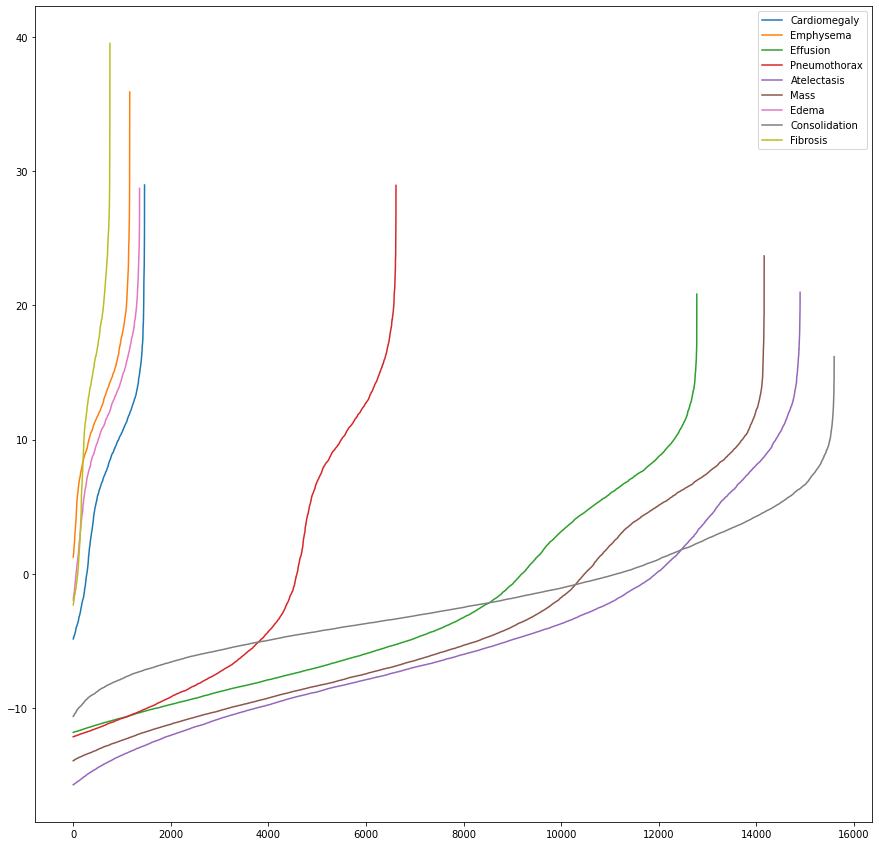

In [ ]:
fig = plt.figure(figsize =( 15,15))
for disease, thresholds in thresh.items():
  plt.plot(range(len(thresholds)), thresholds, label = disease)
  j = 14000
  try:
    print(disease, thresholds[j], precision[disease][j], recall[disease][j], len(thresholds))
  except IndexError:
    pass
  plt.legend()

In [ ]:
def read_torch_img(file):
  img = read_image(file).float()
  img /= 255.
  resize = T.Resize(IMG_SIZE[:2])
  img = resize(img)
  img = mask_img(img)
  return img[None,:]

In [ ]:
!cp -r ./drive/MyDrive/cxr_segment ./utils/cxr_segment
!cp -r ./drive/MyDrive/cxr_segment ./cxr_segment

In [ ]:
import cxr_segment
import importlib
cxr_segment = importlib.reload(cxr_segment)

In [ ]:
!cp -r ./cxr_segment ./drive/MyDrive/cxr_segment

In [ ]:
from cxr_segment.segmentation_model import Segmentation_Model
from cxr_segment.feature_extraction import LungIntepretation

def get_lung_boundaries(file_path):
  segment_model = Segmentation_Model()
  mask = segment_model.get_mask_from_file(file_path)

  lung_interpret = LungIntepretation(mask)
  return lung_interpret.get_cxr_boundaries

def mask_img(img):
  mask = torch.zeros((IMG_SIZE[:2]))
  # min(top) = max(self.top[idx], 0)
  # bottom = min(self.bottom[idx], IMG_SIZE[0])
  # left = max(self.left[idx], 0)
  # right = min(self.right[idx], IMG_SIZE[0])
  top, bottom, left, right = get_lung_boundaries(cxr)
  # print(top,bottom, left, right)
  top, bottom, left, right = min(top) * 354 // 256 , max(bottom)* 414 // 256, min(left)* 324 // 256 , max(right)* 414 // 256
  mask[top: bottom, left : right] = 1
  return img *  mask

In [ ]:
from cxr_segment import get_numeric_data

array([['Cardiomegaly', '1.907602', '-5.6350303', 'False'],
       ['Emphysema', '2.583133', '-0.80505866', 'False'],
       ['Effusion', '0.97622734', '4.66219', 'True'],
       ['Pneumothorax', '-0.05289054', '-13.072199', 'False'],
       ['Atelectasis', '0.6142074', '-3.6093566', 'False'],
       ['Mass', '1.6850727', '-0.098666966', 'False'],
       ['Edema', '1.4499166', '-8.593888', 'False'],
       ['Consolidation', '2.1977124', '11.346601', 'True'],
       ['Fibrosis', '3.480622', '4.0668874', 'True']], dtype='<U32')

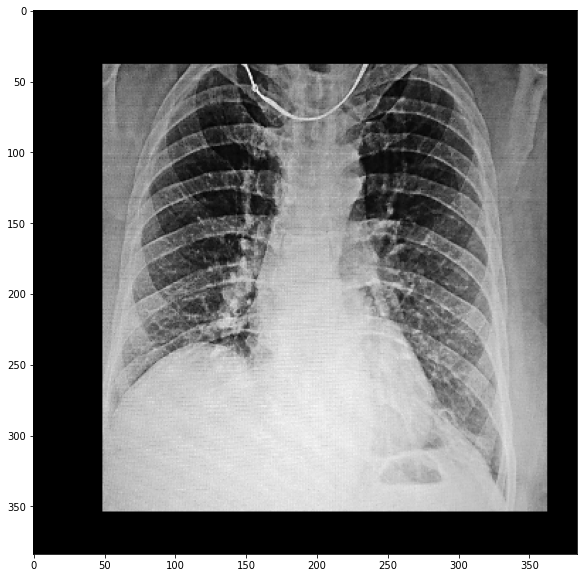

In [ ]:
TB_CXR = './drive/MyDrive/tb_ambala_cxr/'
cxrs = np.random.choice(os.listdir(TB_CXR))
cxr = os.path.join(TB_CXR, cxrs)
img = read_torch_img(cxr)
numeric = cxr_segment.get_numeric_data(cxr)
numeric = torch.tensor(numeric, dtype = torch.float32)
numeric = (numeric - train_ds.numeric_means) / train_ds.numeric_stds
plt.figure(figsize = (10,10))
plt.imshow(img[0,0,:,:], cmap = 'gray')
with torch.no_grad():
  img, numeric = img.to(device), numeric.to(device)
  pred = model(img, numeric[None,:])
pred_numpy = pred.cpu().numpy()[0]
func_thresh_list = [func_thresh[disease] for disease in PATHOLOGY_LIST]
np.array((PATHOLOGY_LIST, func_thresh_list, pred_numpy, pred_numpy > func_thresh_list)).T